<a href="https://colab.research.google.com/github/mukkatharun/DeepLearningAssignments/blob/main/assignemnt7/Part2_ManytoOne_OnetoMany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNN Many to One

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('Tensorflow: {}'.format(tf.__version__))

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

Tensorflow: 2.8.0


In [ ]:
words = ['good', 'bad', 'worse', 'so good']
y = [1, 0, 0, 1]

In [ ]:
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx:char for idx, char in enumerate(char_set)}
char2idx = {char:idx for idx, char in enumerate(char_set)}

In [ ]:
char_set

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']

In [ ]:
idx2char

{0: '<pad>',
 1: ' ',
 2: 'a',
 3: 'b',
 4: 'd',
 5: 'e',
 6: 'g',
 7: 'o',
 8: 'r',
 9: 's',
 10: 'w'}

In [ ]:
char2idx

{' ': 1,
 '<pad>': 0,
 'a': 2,
 'b': 3,
 'd': 4,
 'e': 5,
 'g': 6,
 'o': 7,
 'r': 8,
 's': 9,
 'w': 10}

In [ ]:
X = list(map(lambda word: [char2idx.get(char) for char in word], words))
X_len = list(map(lambda word: len(word), X))

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding the sequence of indices
max_sequence=10

X = pad_sequences(X, maxlen=max_sequence, padding='post', truncating='post')


In [ ]:
# Generate data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=4).batch(batch_size=2)
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
input_dim = len(char2idx)
output_dim = len(char2idx)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, input_length=max_sequence,
              trainable=False, embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10),
    Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 11)            121       
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                220       
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


In [ ]:
def loss_fn(model, X, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true=y, 
                                                                          y_pred=model(X), 
                                                                          from_logits=True))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb)
            
        grads = tape.gradient(tr_loss, sources=model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('epoch: {:3}, tr_loss: {:3f}'.format(e + 1, avg_tr_loss))

epoch:   5, tr_loss: 0.093991
epoch:  10, tr_loss: 0.006448
epoch:  15, tr_loss: 0.002240
epoch:  20, tr_loss: 0.001365
epoch:  25, tr_loss: 0.001042
epoch:  30, tr_loss: 0.000871


In [ ]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1)

In [ ]:
print('acc: {:.2%}'.format(np.mean(y_pred == y)))

acc: 100.00%


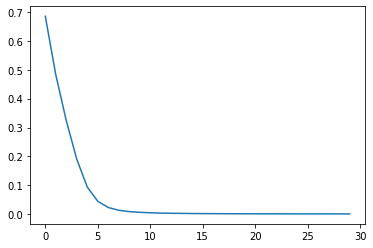

In [ ]:
plt.figure()
plt.plot(tr_loss_hist)
plt.show()

RNN Many To Many

Parts of Speech Tagging

In [ ]:
sentences = [['I', 'feel', 'hungry'],
             ['tensorflow', 'is', 'very', 'difficult'],
             ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
             ['tensorflow', 'is', 'very', 'fast', 'changing']]

pos = [['pronoun', 'verb', 'adjective'], 
       ['noun', 'verb', 'adverb', 'adjective'],
       ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
       ['noun', 'verb', 'adverb', 'adjective', 'verb']]

In [ ]:
word_list =['<pad>'] + sorted(set(sum(sentences, []))) 
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}

print(word_list)
print(word2idx)
print(idx2word)

['<pad>', 'I', 'a', 'changing', 'deep', 'difficult', 'fast', 'feel', 'for', 'framework', 'hungry', 'is', 'learning', 'tensorflow', 'very']
{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}
{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}


In [ ]:
pos_list = ['<pad>'] + sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}

print(pos_list)
print(pos2idx)
print(idx2pos)

['<pad>', 'adjective', 'adverb', 'determiner', 'noun', 'preposition', 'pronoun', 'verb']
{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}
{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}


In [ ]:
X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))

print(X)
print(y)

[[1, 7, 10], [13, 11, 14, 5], [13, 11, 2, 9, 8, 4, 12], [13, 11, 14, 6, 3]]
[[6, 7, 1], [4, 7, 2, 1], [4, 7, 3, 4, 5, 1, 4], [4, 7, 2, 1, 7]]


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X, maxlen=10, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)

print(X)
print(X_mask)
print(X_len)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[3. 4. 7. 5.]


In [ ]:
y = pad_sequences(y, maxlen=10, padding='post')

print(y)

[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X, y, X_len)).shuffle(buffer_size=4).batch(batch_size=2)

print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


Model Implementation



In [ ]:
num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, TimeDistributed, Dense, SimpleRNN

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, trainable=False, input_length=10,
              embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10, return_sequences=True),
    TimeDistributed(Dense(units=num_classes))
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 15)            225       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 10)            260       
                                                                 
 time_distributed (TimeDistr  (None, 10, 8)            88        
 ibuted)                                                         
                                                                 
Total params: 573
Trainable params: 348
Non-trainable params: 225
_________________________________________________________________


In [ ]:
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True
    ) * masking
    sequence_loss = tf.reduce_mean(tf.reduce_sum(sequence_loss, axis=1) / x_len)
    return sequence_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [ ]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb, x_mb_len in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb, x_mb_len, max_sequence=10)
        grads = tape.gradient(tr_loss, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('Epoch: {:3}, tr_loss: {:.3f}'.format(e+1, avg_tr_loss))

Epoch:   5, tr_loss: 0.768
Epoch:  10, tr_loss: 0.254
Epoch:  15, tr_loss: 0.200
Epoch:  20, tr_loss: 0.039
Epoch:  25, tr_loss: 0.013
Epoch:  30, tr_loss: 0.007


In [ ]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1) * X_mask

y_pred

array([[6., 7., 1., 0., 0., 0., 0., 0., 0., 0.],
       [4., 7., 2., 1., 0., 0., 0., 0., 0., 0.],
       [4., 7., 3., 4., 5., 1., 4., 0., 0., 0.],
       [4., 7., 2., 1., 7., 0., 0., 0., 0., 0.]])

In [ ]:
from pprint import pprint

y_pred_pos = list(map(lambda row: [idx2pos.get(elm) for elm in row], y_pred.astype(np.int32).tolist()))

pprint(y_pred_pos)

pprint(pos)

[['pronoun',
  'verb',
  'adjective',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'adverb',
  'adjective',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'determiner',
  'noun',
  'preposition',
  'adjective',
  'noun',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'adverb',
  'adjective',
  'verb',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


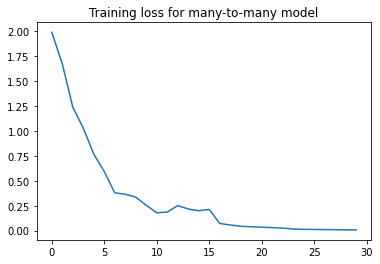

In [ ]:
plt.figure()
plt.plot(tr_loss_hist)
plt.title('Training loss for many-to-many model')
plt.show()